<a href="https://colab.research.google.com/github/gullerkilic/Artbook/blob/main/coding_u_net_for_image_segmentation_ice_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################################################
# for this notebook, got help from the following Resources                                   #
##############################################################################################
# https://www.tensorflow.org/tutorials/images/segmentation                                   #
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose                 #
#                                                                                            #  
# https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47  #
# :~:text=8.-,UNET%20Architecture%20and%20Training,for%20Bio%20Medical%20Image%20Segmentation#
# &text=Thus%20it%20is%20an%20end,accept%20image%20of%20any%20size.                          #
##############################################################################################

##############################################################################################
# This notebook contains Unet for image segmentation                                         #
##############################################################################################

In [ ]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
! apt-get install rar
#!apt-get install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip -uq "/content/drive/My Drive/Colab Notebooks/images/butterfly/butterfly.zip" -d "/content/drive/My Drive/Colab Notebooks/images/butterfly/"
!unrar x "/content/drive/My Drive/EngineeringDesignGroup/horasan/images/Horasan_crack.rar" "/content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/EngineeringDesignGroup/horasan/images/Horasan_crack.rar


Would you like to replace the existing file /content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_mask/100_seg0.png
  5565 bytes, modified on 2022-05-19 14:08
with a new one
  5565 bytes, modified on 2022-05-19 14:08

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_mask/100_seg0.png       0%  OK 
Extracting  /content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_mask/101_seg0.png       0%  OK 
Extracting  /content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_mask/102_seg0.png       0%  OK 
Extracting  /content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_mask

In [ ]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

    
    

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

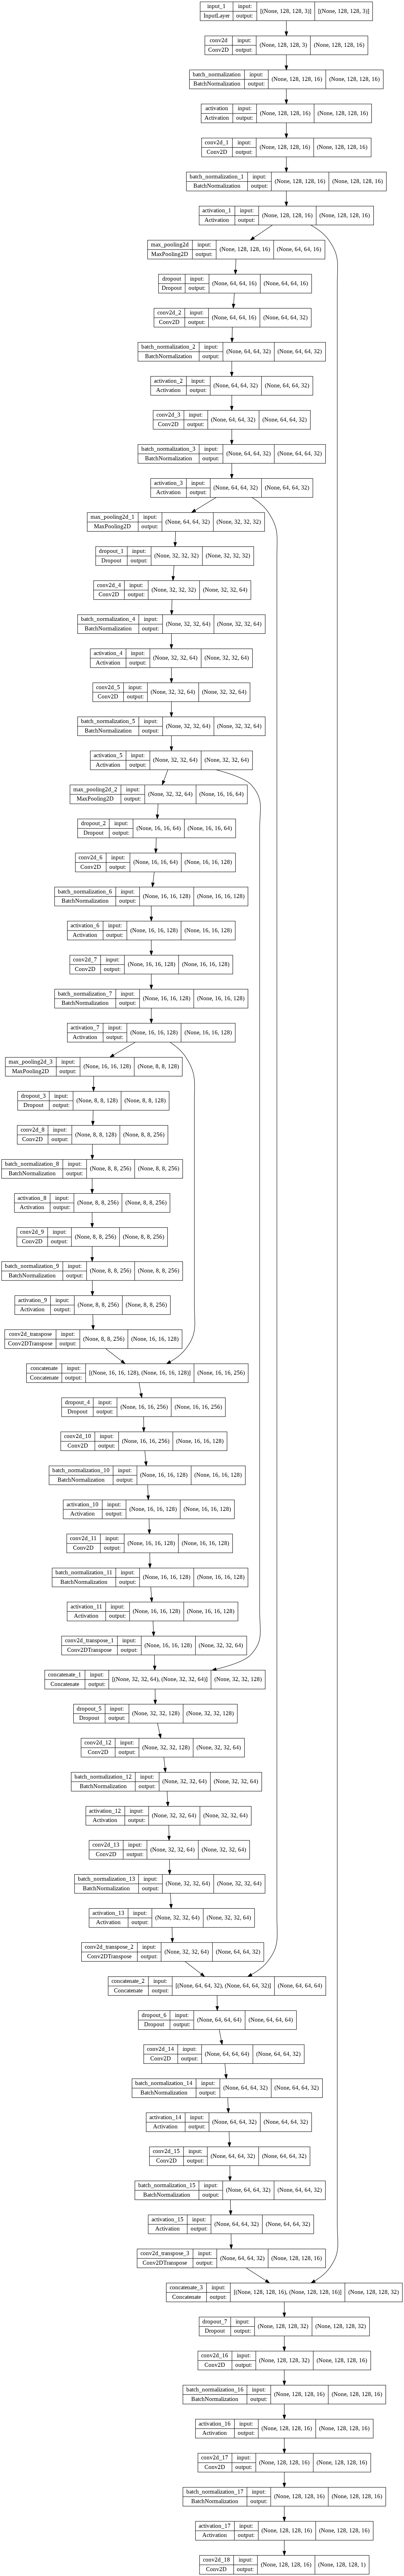

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_seg0.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i]) 
            mask = plt.imread(maskAddr + maskNames[i])
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [ ]:
#@title
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_seg0.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img_ = cv2.imread(imgAddr + imgNames[i])[...,::-1] 
            mask_ = cv2.imread(maskAddr + maskNames[i])[...,::-1]
            img_sized = cv2.resize(img_, (shape, shape))
            mask_sized = cv2.resize(mask_, (shape, shape))
            img = img_to_array(img_sized)
            mask = img_to_array(mask_sized)
            frameObj['img'].append(img)
            frameObj['mask'].append(mask) # this is because its a binary mask and img is present in channel 0
        except Exception as e:
           print(e)
   
    return frameObj

In [ ]:
#@title
"""framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/butterfly-dataset/leedsbutterfly/images', 
                        maskPath = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'
                         , shape = 256)"""

In [ ]:
#Resimlerin bit derinliği 24 olmalı
framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_png', 
                        maskPath = '/content/drive/My Drive/EngineeringDesignGroup/horasan/after_image/Horasan_crack/Horasan_mask'
                         , shape = 128)

In [ ]:
np.array(framObjTrain['img']).shape
            

(247, 128, 128, 3)

In [ ]:
np.array(framObjTrain['mask']).shape   

(247, 128, 128)

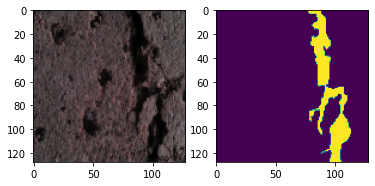

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [ ]:
hist = unet.fit(
    np.array(framObjTrain['img']), np.array(framObjTrain['mask']), 
    epochs=100,
    verbose=1).history

Epoch 1/100
8/8 [==============================] - 18s 282ms/step - loss: 0.5630 - accuracy: 0.7883
Epoch 2/100
8/8 [==============================] - 1s 93ms/step - loss: 0.3784 - accuracy: 0.9536
Epoch 3/100
8/8 [==============================] - 1s 94ms/step - loss: 0.2847 - accuracy: 0.9759
Epoch 4/100
8/8 [==============================] - 1s 93ms/step - loss: 0.2304 - accuracy: 0.9782
Epoch 5/100
8/8 [==============================] - 1s 93ms/step - loss: 0.1991 - accuracy: 0.9797
Epoch 6/100
8/8 [==============================] - 1s 93ms/step - loss: 0.1794 - accuracy: 0.9799
Epoch 7/100
8/8 [==============================] - 1s 94ms/step - loss: 0.1645 - accuracy: 0.9800
Epoch 8/100
8/8 [==============================] - 1s 93ms/step - loss: 0.1538 - accuracy: 0.9800
Epoch 9/100
8/8 [==============================] - 1s 93ms/step - loss: 0.1427 - accuracy: 0.9802
Epoch 10/100
8/8 [==============================] - 1s 95ms/step - loss: 0.1351 - accuracy: 0.9804
Epoch 11/100
8/8 

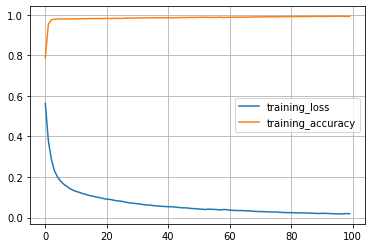

In [ ]:
plt.plot(hist['loss'], label = 'training_loss')
plt.plot(hist['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
# Predict on val
img = framObjTrain['img']
mask = framObjTrain['mask']
X_val = np.array(img)
Y_val = np.array(mask)
preds_val = unet.predict(X_val, verbose=1)
# Threshold predictions
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5)

8/8 [==============================] - 1s 33ms/step


In [ ]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [ ]:
# calcualte average iou of validation images, the result from tensorflow seems too high. 
iou=[]
for i in range(len(Y_val)):
    iou.append(cal_iou(np.squeeze(Y_val[i]), np.squeeze(preds_val_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

Average Validate IOU: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


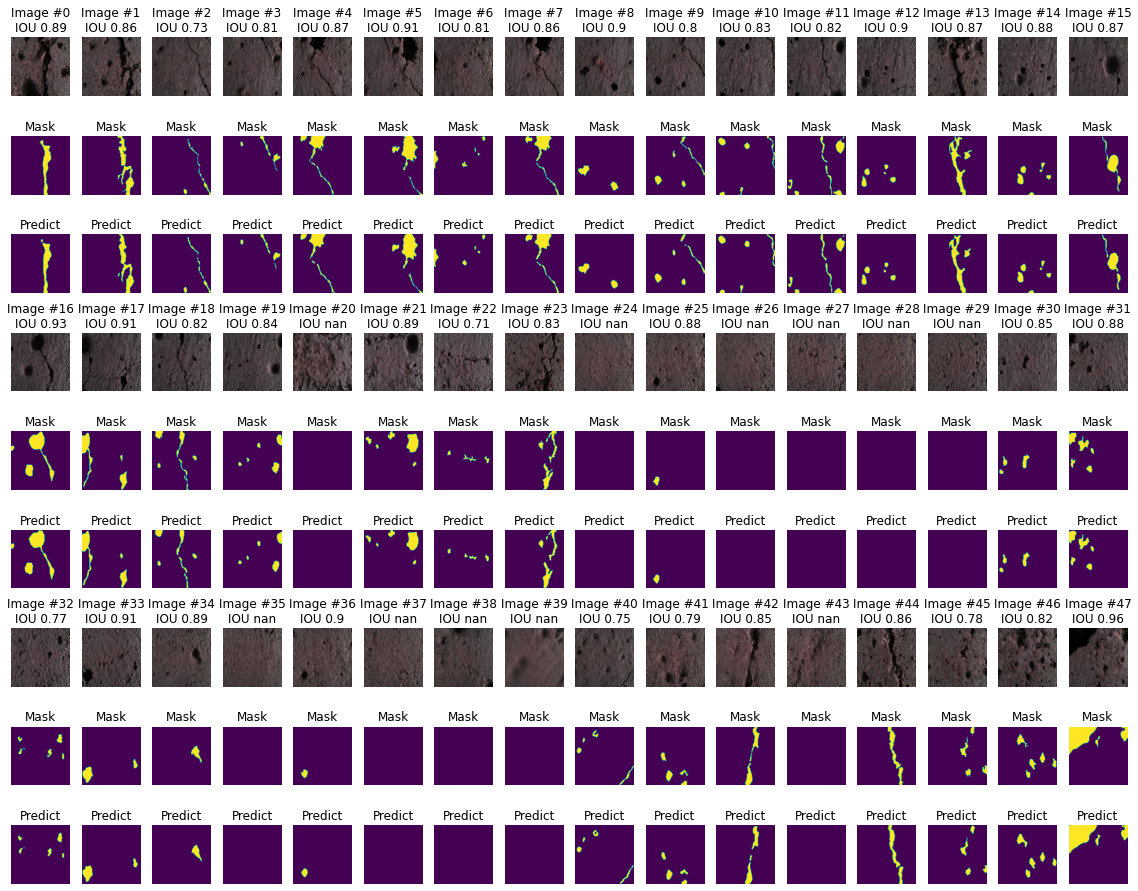

In [ ]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(20,16))
x, y = 16,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_val[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_val[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()


In [ ]:
#@title
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
   
    #
    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('image')

    plt.subplot(1,4,2)
    plt.imshow(groundTruth, cmap = 'magma', interpolation = 'none')
    plt.title('actual Mask')

    plt.subplot(1,4,3)
    plt.imshow(predMask, cmap = 'bone', interpolation = 'none')
    #plt.title('Predicted Mask | jacard {:.3f}'.format(jacard))
    plt.title('Predicted Mask')
    #plt.title('predicted Mask\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val), np.squeeze(preds_val_t)),2)))
  

    plt.subplot(1,4,4)
    plt.imshow(img, cmap = 'plasma', interpolation = 'none')
    plt.imshow(predMask, cmap = 'bone', interpolation = 'none', alpha = 0.6)

    plt.title('segmented Image')

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

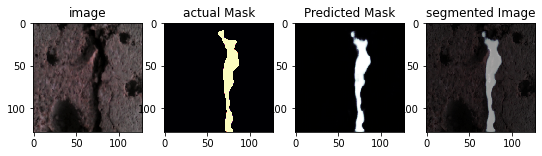

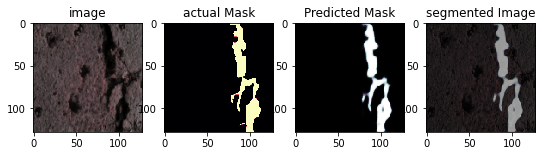

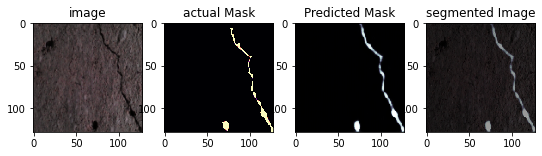

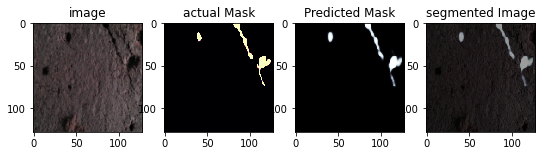

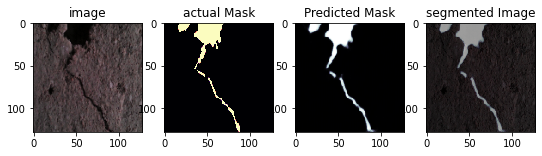

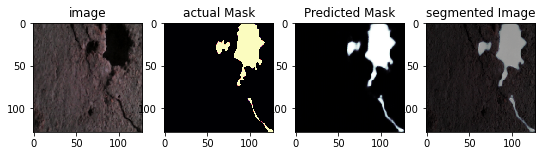

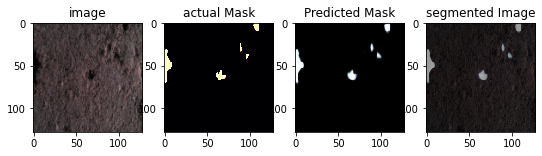

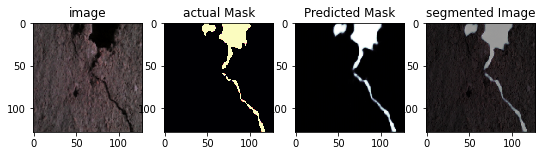

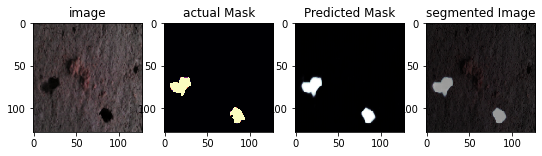

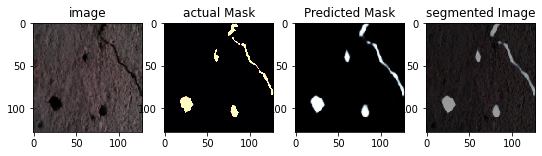

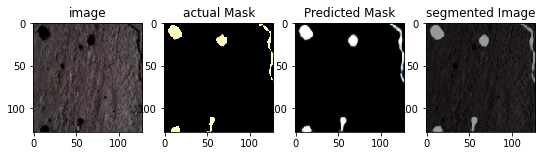

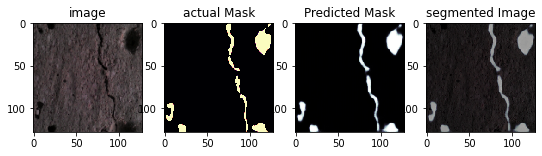

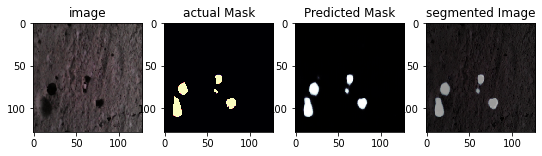

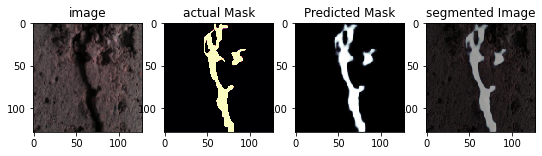

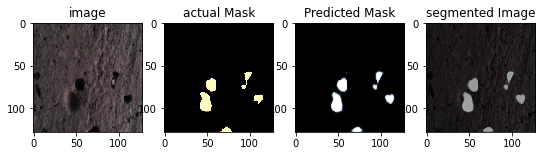

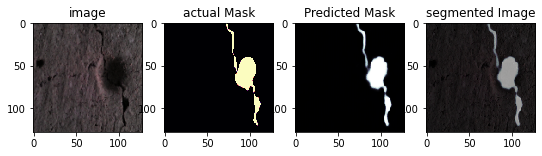

In [ ]:
for im in range(16):
  Plotter(actuals[im], sixteenPrediction[im][:,:,0], masks[im])

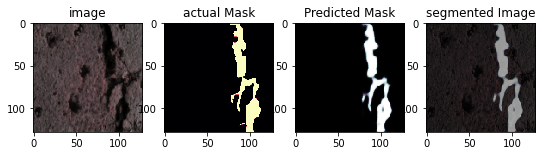

In [ ]:
im=1
Plotter(actuals[im], sixteenPrediction[im][:,:,0], masks[im])

In [ ]:
# defining function for dataLoading function
framObjValid = {'img' : [],
           'mask' : []
          }

In [ ]:
#Resimlerin bit derinliği 24 olmalı
dir_real='/content/drive/My Drive/EngineeringDesignGroup/horasan/test/png'
dir_masked='/content/drive/My Drive/EngineeringDesignGroup/horasan/test/mask'
framObjValid = LoadData(framObjValid, imgPath = dir_real,
                        maskPath = dir_masked,
                        shape = 128)

In [ ]:
np.array(framObjValid['img']).shape
            

(20, 128, 128, 3)

In [ ]:
np.array(framObjValid['mask']).shape   

(20, 128, 128)

In [ ]:
list = os.listdir(dir_real) # dir is your directory path
number_files = len(list)
print(number_files)

20


In [ ]:
def predict_valid (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:number_files]
    
    imgProc = img [0:number_files]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  
    return predictions, imgProc, mask

In [ ]:
Prediction_valid, actuals, masks = predict_valid(framObjValid, unet)

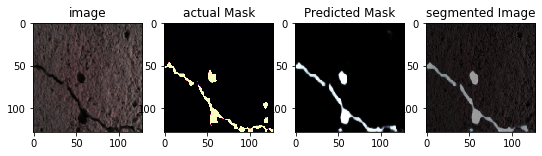

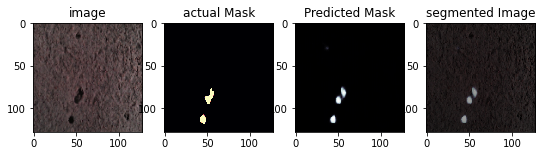

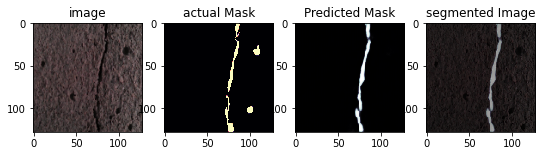

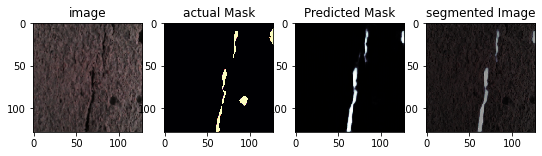

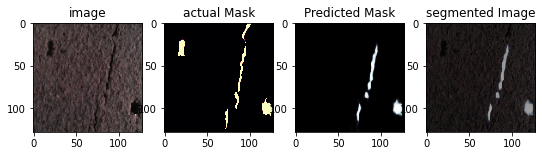

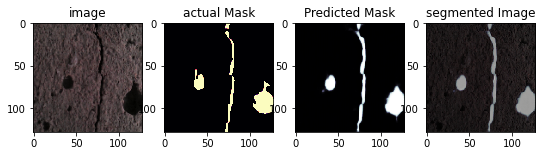

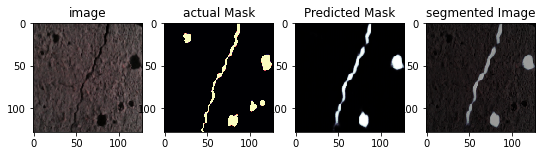

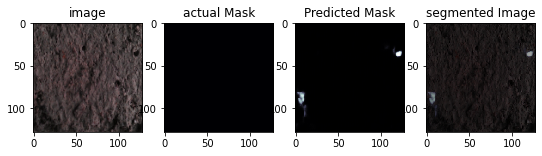

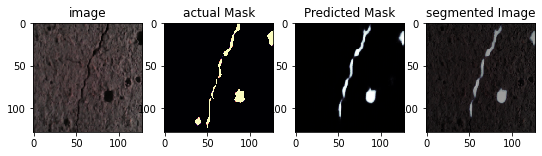

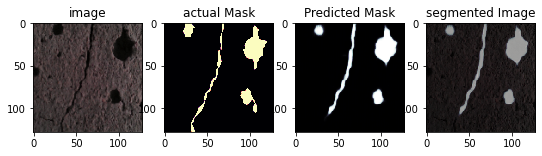

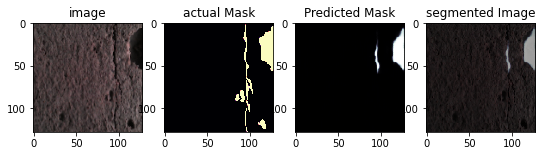

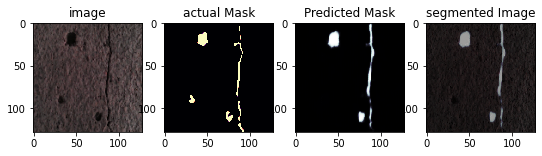

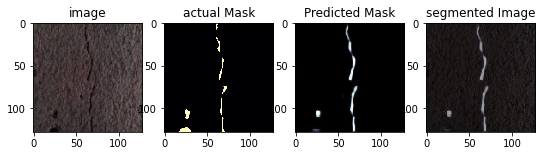

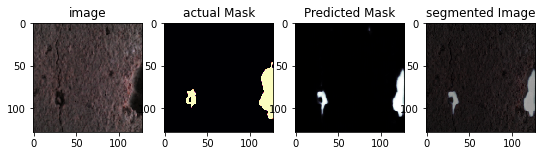

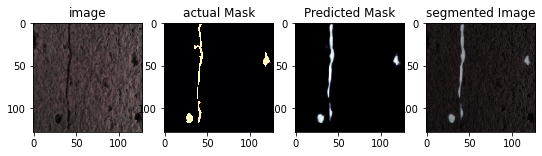

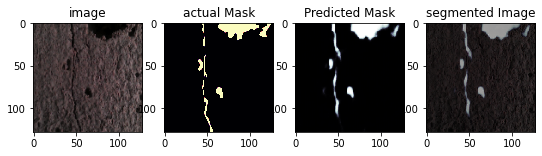

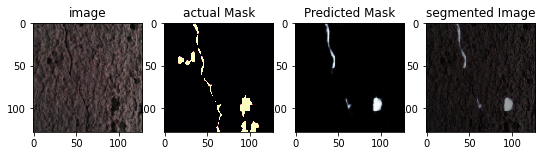

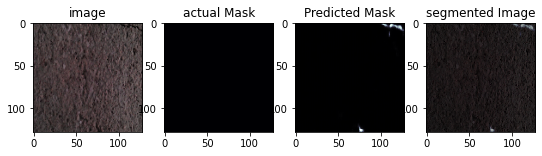

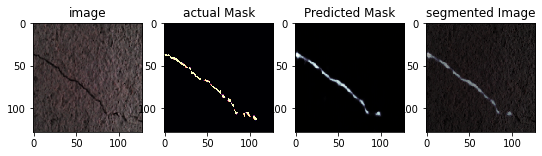

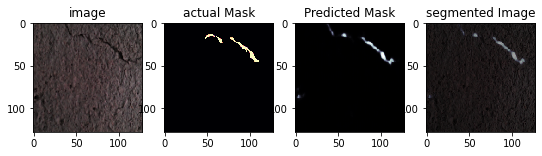

In [ ]:
count = 0
while (count <number_files):
   Plotter(actuals[count], Prediction_valid[count][:,:,0], masks[count])
   count = count + 1

In [ ]:
# Predict on val
img = framObjValid['img']
mask = framObjValid['mask']
X_val = np.array(img)
Y_val = np.array(mask)
preds_val = unet.predict(X_val, verbose=1)
# Threshold predictions
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5)

1/1 [==============================] - 0s 22ms/step


In [ ]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [ ]:
# calcualte average iou of validation images, the result from tensorflow seems too high. 
iou=[]
for i in range(len(Y_val)):
    iou.append(cal_iou(np.squeeze(Y_val[i]), np.squeeze(preds_val_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

Average Validate IOU: 0.49


IndexError: ignored

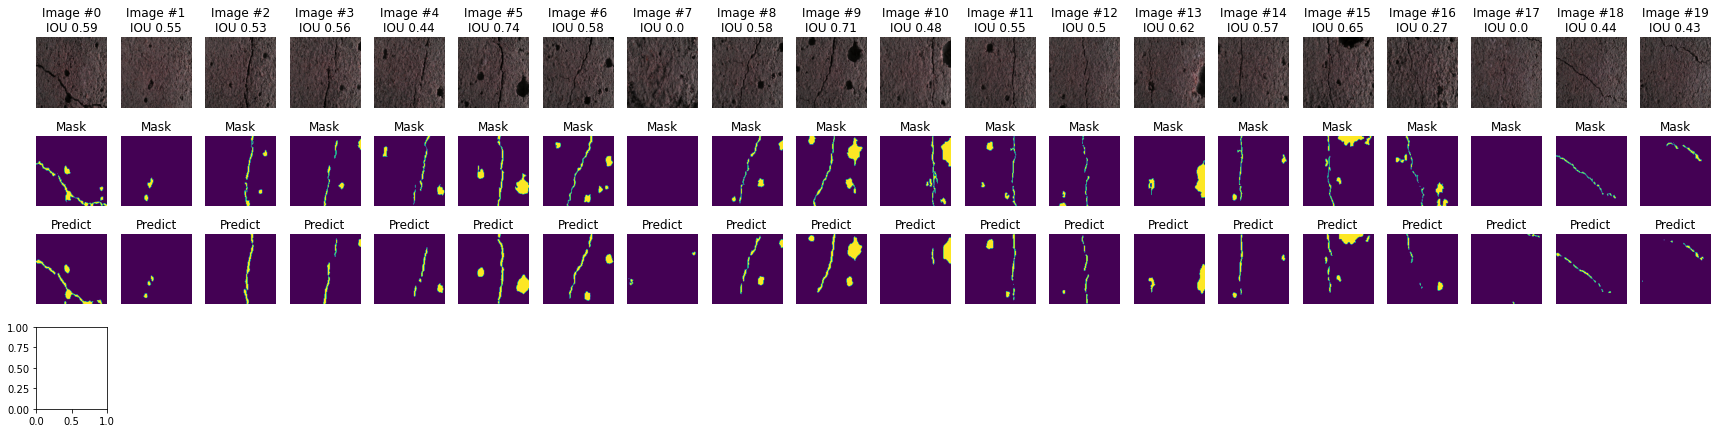

In [ ]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(30,16))
x, y = count,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_val[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_val[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()
